# End to End Analysis - Time Series

In [47]:
#Importing the required libraries for TSA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import itertools

If you get an error here, please check if you have all the python libraries installed . If not, use the 'pip install' command in the command prompt or the anaconda prompt.

In [48]:
#to ignore warning messages
import warnings
warnings.filterwarnings("ignore")

In [49]:
#loading the file into Python

df1 = pd.read_csv("sales-data.csv")
df1.head()

,Month,Sales
0,1,154
1,2,96
2,3,73
3,4,49
4,5,36


First, we will break the time series into two parts: 'Train' and 'Test' for analysis. We will try to formulate a model using the 'train' part and then implement the obtained model on the 'test' to verify the correctness of the model.

In [50]:
#We will create the model using the first 71 rows
#Then we can test the model on the remaining 6 rows later

indata = df1.iloc[0:70,:]
outdata = df1.iloc[70:,:]

total_timeser = df1["Sales"]

train = indata.iloc[:,1] 
test = outdata.iloc[:,1]

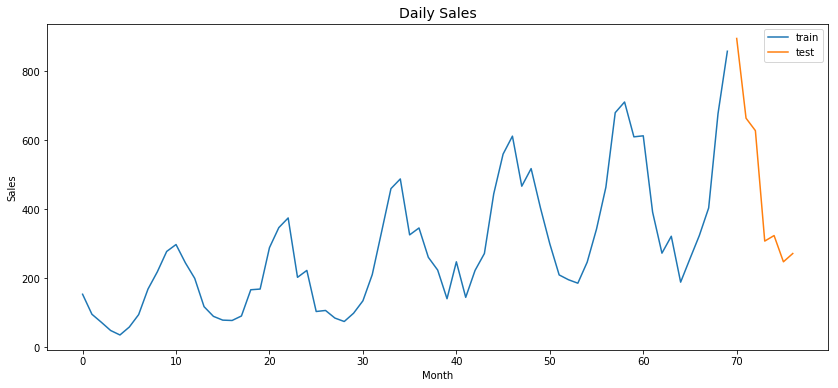

In [51]:
#Plotting the train and test

plt.figure(figsize=(14,6))
plt.plot(train, label = 'train')
plt.plot(test, label = 'test')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Daily Sales', fontsize=14)
plt.legend(loc='best')
plt.show()

In [52]:
#Smoothing the series - Moving Average Smoothing (2 sided)

from astropy.convolution import convolve, Box1DKernel
width = 3
smoothedseries = convolve(np.array(list(train)), kernel=Box1DKernel(width))

Please note that separate smoothing of the left end and the right end of the series has to be done to remove the missing values. In case of width = 1, there is only one missing value generated at both the ends. However, if the width of the averaging window is increased, the number of missing values will also increase.

In [53]:
smoothedseries

array([ 83.33333333, 107.66666667,  72.66666667,  52.66666667,
        48.        ,  63.33333333, 107.66666667, 161.        ,
       222.        , 265.        , 273.66666667, 247.66666667,
       187.66666667, 136.        ,  95.66666667,  82.33333333,
        82.66666667, 112.        , 142.33333333, 208.33333333,
       268.33333333, 337.        , 308.33333333, 267.        ,
       176.66666667, 144.66666667,  98.66666667,  89.        ,
        86.33333333, 103.        , 148.33333333, 227.        ,
       335.33333333, 427.66666667, 424.66666667, 386.66666667,
       311.        , 277.        , 208.66666667, 204.33333333,
       178.        , 205.33333333, 213.33333333, 313.33333333,
       425.66666667, 539.        , 546.33333333, 532.33333333,
       463.        , 407.33333333, 304.66666667, 235.33333333,
       197.33333333, 209.66666667, 258.66666667, 351.33333333,
       495.66666667, 618.33333333, 667.        , 644.66666667,
       538.33333333, 426.        , 329.        , 261.33

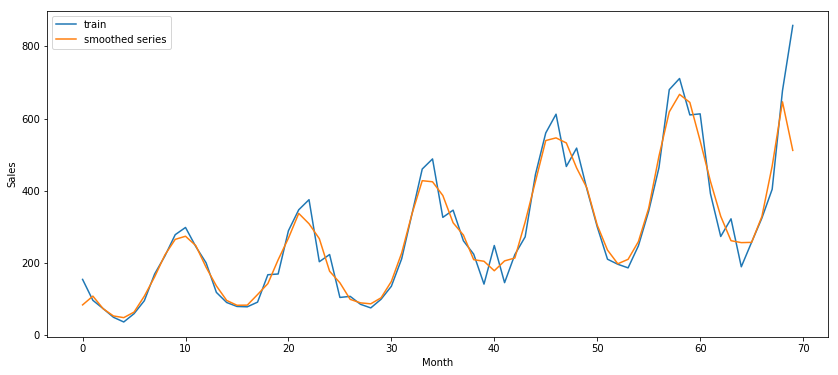

In [54]:
#Plot the smoothed time series

plt.figure(figsize = (14,6))
plt.plot(train, label = 'train')
plt.plot(smoothedseries, label = 'smoothed series')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend(loc = 'best')
plt.show()

In [55]:
#Smoothing left end of the time series
diff = smoothedseries[2] - smoothedseries[1]
smoothedseries[0] = smoothedseries[1] - diff

#Smoothing right end of the time series
n = len(train)
diff = smoothedseries[n-2] - smoothedseries[n-3]
smoothedseries[n-1] = smoothedseries[n-2] + diff

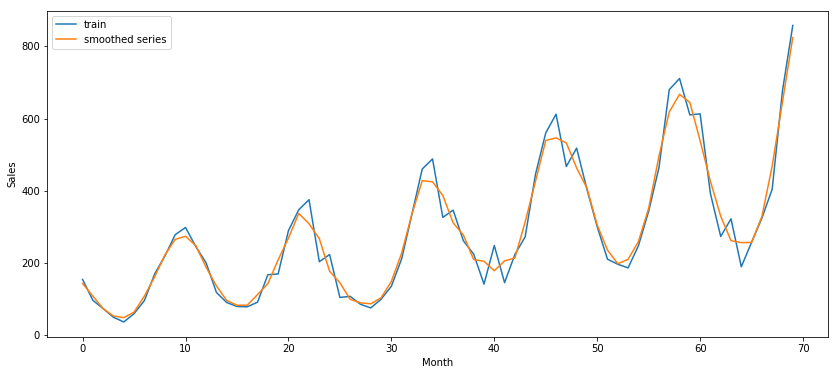

In [56]:
#Plot the smoothed time series

plt.figure(figsize = (14,6))
plt.plot(train, label = 'train')
plt.plot(smoothedseries, label = 'smoothed series')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend(loc = 'best')
plt.show()

## Classical Decomposition Method

Here, we will use the manual classical decomposition technique. We will try to fit the trend and seasonal components using a function and then obtain the locally predictable part by subtracting the trend and seasonal components from the overall series.

In [57]:
#Preparing values for model

x_data = indata.Month
y_data = smoothedseries

In [58]:
#Testing a model using sin, cos and polynomial functions
#Predicting the coefficients of the polynomial functions using a test function
#model = sin() * poly(degree = 3) + cos() * poly(degree = 3) + poly(degree = 1)

from scipy import optimize

def test_func(x, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10):
    return (np.sin(0.5*x) * (p1 + p2*x + p3*(x**2) + p4*(x**3)) 
            + np.cos(0.5*x) * (p5 + p6*x + p7*(x**2) + p8*(x**3)) + p9*(x) + p10)

params, params_covariance = optimize.curve_fit(test_func, x_data, y_data)
print(params)

[-2.27336996e+01 -6.64607152e+00  1.16382102e-01 -9.68334601e-04
  9.48542790e+01 -7.77173780e+00  2.75568117e-01 -3.19766999e-03
  5.87250631e+00  7.60132575e+01]


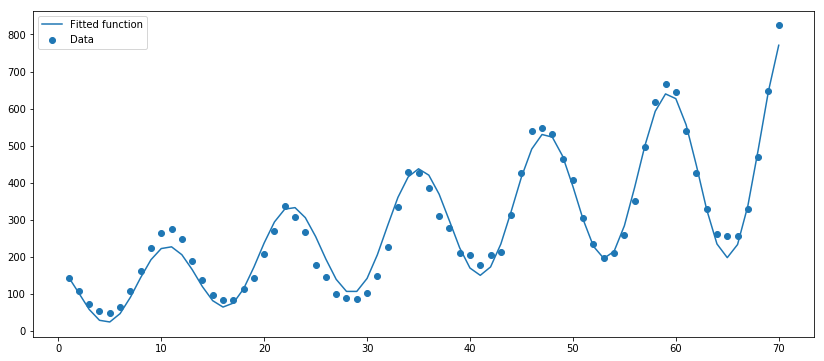

In [59]:
#Plotting the tested model obtained using the curve_fit

plt.figure(figsize=(14, 6))
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, test_func(x_data, params[0], params[1], params[2], params[3], params[4],
                           params[5], params[6], params[7], params[8], params[9]), label='Fitted function')
plt.legend(loc='best')
plt.show()

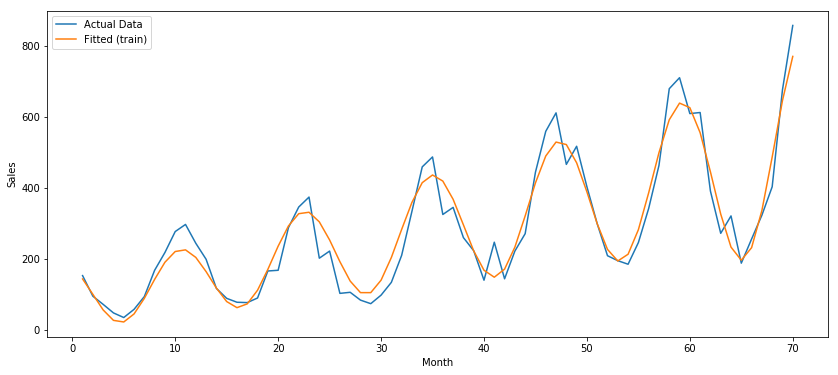

In [60]:
#Fitting the model obtained on the time series using lmfit library in Python 

from lmfit import Model

def pred_global(x):
    return (np.sin(0.5*x) * (params[0] + params[1]*x + params[2]*(x**2) + params[3]*(x**3)) + 
             np.cos(0.5*x) * (params[4] + params[5]*x + params[6]*(x**2) + params[7]*(x**3)) + (params[8]*(x) + params[9]))

global_model = Model(pred_global)
result = global_model.fit(y_data, x = x_data)

plt.figure(figsize = (14,6))
plt.plot(indata.Month, indata.Sales, label = 'Actual Data')
plt.plot(x_data, result.best_fit, label = 'Fitted (train)')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend(loc='best')
plt.show()

In [61]:
#Model provides us with trend and seasonal component of the time series

global_pred = global_model.eval(x=x_data)
global_pred.describe()

count     70.000000
mean     282.595238
std      170.475932
min       23.492179
25%      153.415364
50%      234.154463
75%      389.000557
max      770.897980
Name: Month, dtype: float64

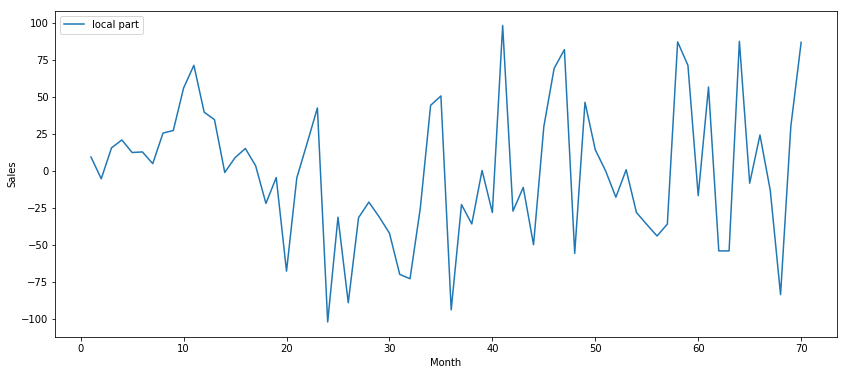

In [62]:
#Now, let's look at the locally predictable series
#We will use the ARIMA model on the obtained series

local_pred = train - global_pred

plt.figure(figsize = (14,6))
plt.plot(indata.Month, local_pred, label = 'local part')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.show()

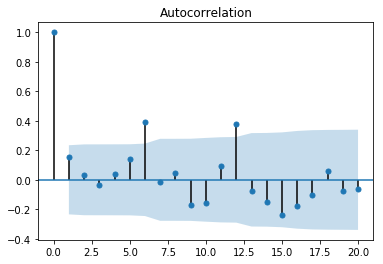

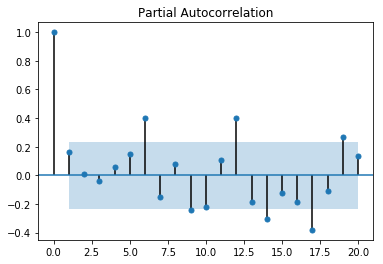

In [63]:
#ACF and PACF plots for the local_pred series obtained

import statsmodels.graphics.tsaplots as tsa
tsa.plot_acf(local_pred, lags=20)
tsa.plot_pacf(local_pred, lags=20)
plt.show()

In this plot, the two shaded region on either sides of x axis are the confidence interevals. The correlation value between two different lags is marked by the vertical sticks. These values can be used to determine the ‘p’ and ‘q’ values for the ARIMA model.

p-value will correspond to the lag value where the PACF chart crosses the upper confidence interval for the first time. q-value will be where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=1 and q=1.

Now, lets prepare the ARIMA model taking p and q as 1.

In [64]:
#Importing ARIMA for time series analysis

from statsmodels.tsa.arima_model import ARIMA

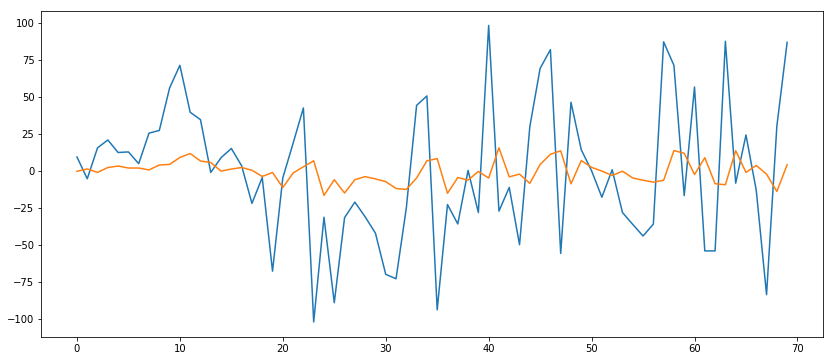

In [65]:
#The best fit model obtained using the ACF and PACF graphs is using p,q = 1

arima_model = ARIMA(local_pred, order=(1, 0, 1))
results_ARIMA = arima_model.fit(disp=-1)

plt.figure(figsize = (14,6))
plt.plot(local_pred)
plt.plot(results_ARIMA.fittedvalues)

plt.show()

### Stationarity Tests

In [66]:
#Now let's check if the residual series is white noise
# 1. Augmented Dicky Fuller (ADF) test

residual = local_pred - results_ARIMA.fittedvalues

import statsmodels.tsa.stattools as ts

#removing the null values from the residual series
residual1 = residual[~residual.isnull()]
adf_test = ts.adfuller(residual1, autolag='AIC')

print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.703735
p-value: 0.429189
Critical Values:
	1%: -3.548
	5%: -2.913
	10%: -2.594


The p-value obtained using the ADF Test is .... than 0.05. Therefore, ....

In [67]:
# 2. KPSS test

kpss_test = ts.kpss(residual1, regression='c', store=False)
print('KPSS Statistic: %f' % kpss_test[0])
print('p-value: %f' % kpss_test[1])
print('Critical Values:')
for key, value in kpss_test[3].items():
	print('\t%s: %.3f' % (key, value))

KPSS Statistic: 0.122948
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


The p-value obtained using the KPSS Test is .... than 0.05. Therefore, ....

Since the residual series obtained is white noise, we can say that the model that we prepared will be a good fit to the time series. Therefore, we will now try to fit our predicted function on the 'test' part and check how apt our model is.

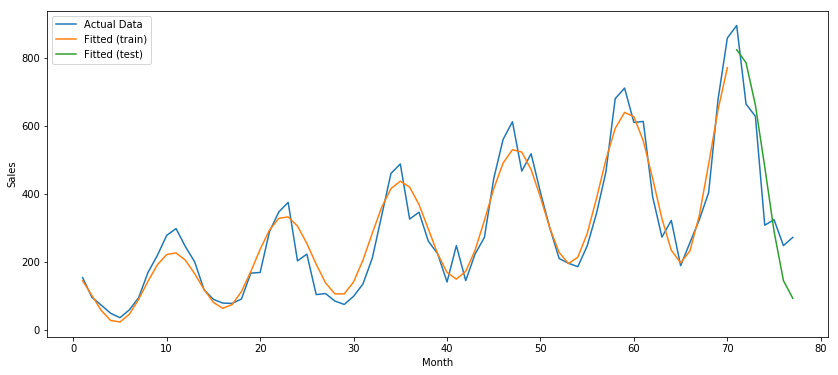

In [68]:
#Predicting the test part of the time series

x_data = indata.iloc[:,0]
y_data = train

x_test = outdata.iloc[:,0]
y_test = test

model = Model(pred_global)

result_train = model.fit(y_data, x=x_data)
result_test = model.fit(y_test, x=x_test)

plt.figure(figsize = (14,6))

plt.plot(df1.Month, df1.Sales, label = 'Actual Data')
plt.plot(x_data, result_train.best_fit, label = 'Fitted (train)')
plt.plot(x_test, result_test.best_fit, label = 'Fitted (test)')

plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend(loc='best')
plt.show()

In [69]:
#Comparing the predicted values with the actual values

index = np.arange(6)
classical_compare = pd.DataFrame(columns = ['Actual', 'Predicted'], index = index)
for i in range(len(outdata)):
    classical_compare['Actual'][i] = y_test.iloc[i]
    classical_compare['Predicted'][i] = round((result_test.best_fit.iloc[i]),0)
print(classical_compare)


  Actual Predicted
0    895       824
1    664       785
2    628       661
3    308       480
4    324       290
5    248       145


### Model Evaluation - MAPE

Now, let's compare our prediction with the actual values using MAPE. The lesser the Mean absolute percentage error, better the model is.

In [70]:
#Calculating MAPE for Classical Decomposition Method

global_pred_test = result_test.eval(x=x_test)
n = len(global_pred_test)
total = 0
for i in range(n):
    total = total + np.absolute((100*(test.iloc[i] - global_pred_test.iloc[i])/test.iloc[i]))

MAPE = total/n
print("MAPE Value: {}".format(round(MAPE,4)))

MAPE Value: 29.3082


 The MAPE value comes out to be 29.31 which signifies that it is a good fit for the series.

## Auto ARIMA Method

Now, we will use the Auto ARIMA technique. We will try to fit an auto ARIMA model using the 'SARIMAX tool' present in the 'statsmodels' library. SARIMAX tool in Python helps us to estimate a series by incorporating the seasonal and trend effects together in a model.

In [71]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)


In [72]:
#iteration over all the combinations of (p,d,q)

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{} - BIC:{}'.format(param, param_seasonal, round(results.aic,4), round(results.bic,4)))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1001.5176 - BIC:1003.7517
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:794.5039 - BIC:798.59
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:676.6485 - BIC:678.6915
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:533.9628 - BIC:537.5762
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:634.5243 - BIC:638.6452
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:619.8571 - BIC:625.9863
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:535.4383 - BIC:539.0956
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:518.7065 - BIC:524.1264
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:924.4891 - BIC:928.9281
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:734.8153 - BIC:740.8913
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:645.5379 - BIC:649.5886
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:513.1981 - BIC:518.5506
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:632.9043 - BIC:639.0856
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:608.4471 - BIC:616.5485
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:530.7646 - BIC:536.2505
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:506.4537 - BIC:513.5904
ARIMA(0, 1, 0)x(0, 0, 0,

The output of our code suggests that SARIMAX(0, 1, 1)x(0, 1, 1, 12) yields the lowest AIC (477.216) and BIC (482.499) values. We should therefore consider this to be optimal option out of all the models we have considered.

In [73]:
#Fitting the ARIMA model on the train series

arima_model_train = sm.tsa.statespace.SARIMAX(train,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_arima_train = arima_model_train.fit()

print(results_arima_train.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4210      0.145     -2.894      0.004      -0.706      -0.136
ma.S.L12      -0.0713      0.189     -0.378      0.706      -0.441       0.298
sigma2      3363.1232    758.456      4.434      0.000    1876.576    4849.671


Here, we can see that the model is not a good fit. If we check the standard error values obtained from the model, they are comparable to the coefficient values. Hence, the ARIMA model obtained should not be a good fit.

In [74]:
#Predicted values based on ARIMA model

pred_arima_train = results_arima_train.get_prediction(dynamic=False)
pred_arima_train_ci = pred_arima_train.conf_int()

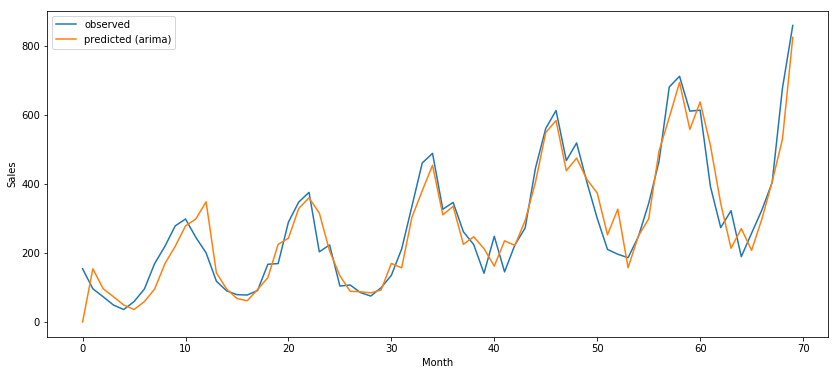

In [75]:
#Plotting the predicted and actual data together

plt.figure(figsize = (14,6))

plot1 = train.plot(label='observed')
pred_arima_train.predicted_mean.plot(ax=plot1, label='predicted (arima)')

plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend(loc = 'best')
plt.show()

### Stationarity Tests

In [76]:
#Now let's check if the residual series is white noise
# 1. Augmented Dicky Fuller (ADF) test

residual = pred_arima_train.predicted_mean - train

#removing the null values from the residual series
residual1 = residual[~residual.isnull()]
adf_test = ts.adfuller(residual1, autolag='AIC')

print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.975612
p-value: 0.037236
Critical Values:
	1%: -3.546
	5%: -2.912
	10%: -2.594


The p-value obtained using the ADF Test is .... than 0.05. Therefore, ....

In [77]:
# 2. KPSS test

kpss_test = ts.kpss(residual1, regression='c', store=False)
print('KPSS Statistic: %f' % kpss_test[0])
print('p-value: %f' % kpss_test[1])
print('Critical Values:')
for key, value in kpss_test[3].items():
	print('\t%s: %.3f' % (key, value))

KPSS Statistic: 0.103249
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


The p-value obtained using the KPSS Test is .... than 0.05. Therefore, ....

Since the residual series obtained is white noise, we can say that the model that we prepared will be a good fit to the time series. Therefore, we will now try to fit our predicted function on the entire series and check how apt our model is.

In [78]:
#Fitting the ARIMA model on the train series

arima_model = sm.tsa.statespace.SARIMAX(total_timeser,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_arima = arima_model.fit()

print(results_arima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3319      0.144     -2.303      0.021      -0.614      -0.049
ma.S.L12      -0.2606      0.164     -1.593      0.111      -0.581       0.060
sigma2      4227.1426    930.226      4.544      0.000    2403.932    6050.353


Here also, we can see that the model is not a good fit. If we check the standard error values obtained from the model, they are comparable to the coefficient values. Hence, the ARIMA model obtained should not be a good fit.

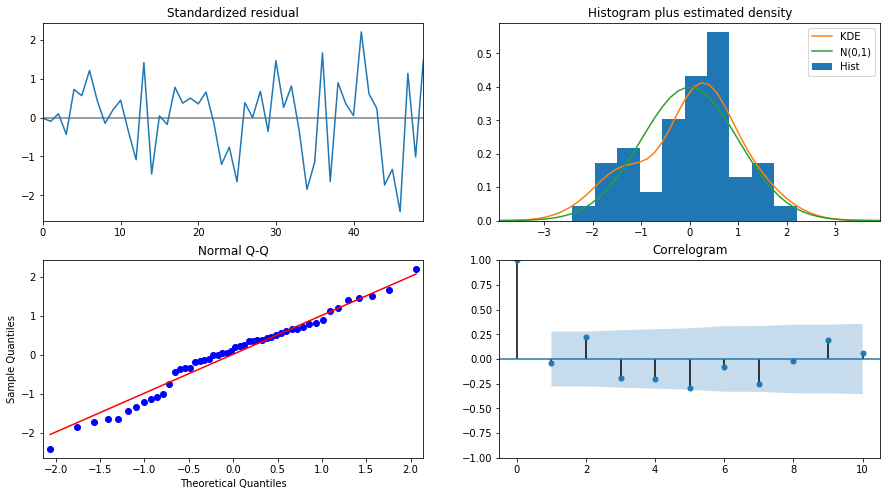

In [79]:
#Model diagnostics

results_arima.plot_diagnostics(figsize=(15, 8))
plt.show()

In the top right plot, we can see that the red line follows the green line which is the normal distribution with mean 0 and standard deviation of 1 but not in a close fashion. Similar is the case with the qq-plot. On the bottom left, it can be improved to fit the linear line better.

If we see the top left graph, we cannot find any distinguished pattern for seasonality. It appears as white noise and since, the ACF plot has all the values under the confidence interval, it can be established that the values do not have any relationship with the past values.

Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values. However, one can always find some scope of improvement in the model obtained.



In [80]:
#Predicted values based on ARIMA model

pred_arima = results_arima.get_prediction(dynamic=False)
pred_arima_ci = pred_arima.conf_int()

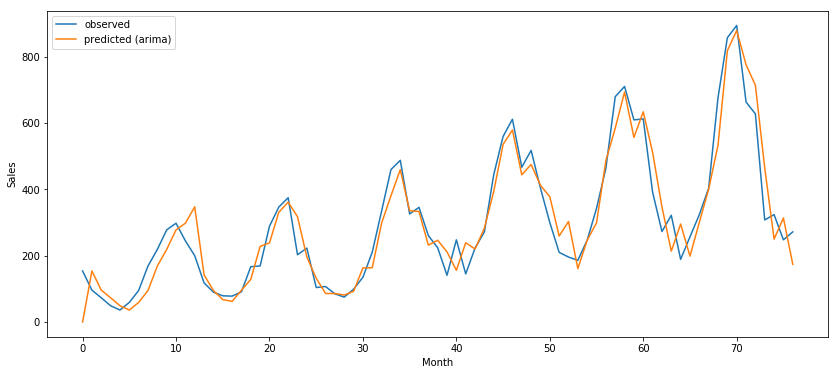

In [81]:
#Plotting the predicted and actual data together

plt.figure(figsize = (14,6))

plot1 = total_timeser.plot(label='observed')
pred_arima.predicted_mean.plot(ax=plot1, label='predicted (arima)')

plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend(loc = 'best')
plt.show()

### Model Evaluation - MAPE

Now, let's compare our prediction with the actual values using MAPE. The lesser the Mean absolute percentage error, better the model is.

In [82]:
#Calculating MAPE for Auto ARIMA Method

arima_pred_test = pred_arima.predicted_mean[70:]
n = len(arima_pred_test)
total = 0
for i in range(n):
    total = total + np.absolute((100*(test.iloc[i] - arima_pred_test.iloc[i])/test.iloc[i]))

MAPE = total/n
print("MAPE Value: {}".format(round(MAPE,4)))

MAPE Value: 24.1172


The MAPE value comes out to be 24.12 which signifies that it is a good fit for the series.